In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import scipy as sp
import seaborn as sns
#from plotting import annotate_cor
#from matplotlib.lines import Line2D
#from functools import partial
#from scipy import stats

sns.set(style='ticks', context='paper',
        rc={'font.size': 6, 
            'axes.titlesize': 7,
            'axes.labelsize': 7,
            'axes.labelpad': 2,
            'xtick.labelsize': 5,
            'ytick.labelsize': 5,
            'legend.title_fontsize' : 5.5,
            'legend.fontsize' : 5.5,
            'legend.markerscale': 0.5,
            'axes.spines.top': False,
            'axes.spines.right': False,
            'axes.linewidth': 0.4,
            'xtick.major.width': 0.4,
            'ytick.major.width': 0.4,
            'xtick.major.size': 2.5,
            'ytick.major.size': 2.5,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.minor.width': 0.2,
            'ytick.minor.width': 0.2,
            'figure.constrained_layout.use': True,
            'figure.dpi': 200})

id_columns = ['architecture', 'task', 'kind', 'source', 'layer']

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu', 
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu', 
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu', 
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}

position_tf_to_pt_map = {}
for l in ['encode_8', 'encode_9']:
    for x in range(7):
        for y in range(7):
            p = f'.position{x}x{y}'
            tf = l+p
            if l == 'encode_8':
                position_tf_to_pt_map[tf] = 'layer4.0.relu'+p
            if l == 'encode_9':
                position_tf_to_pt_map[tf] = 'layer4.1.relu'+p


#data = pd.merge(pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigspectra_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'), pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigmetrics_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),on=id_columns)


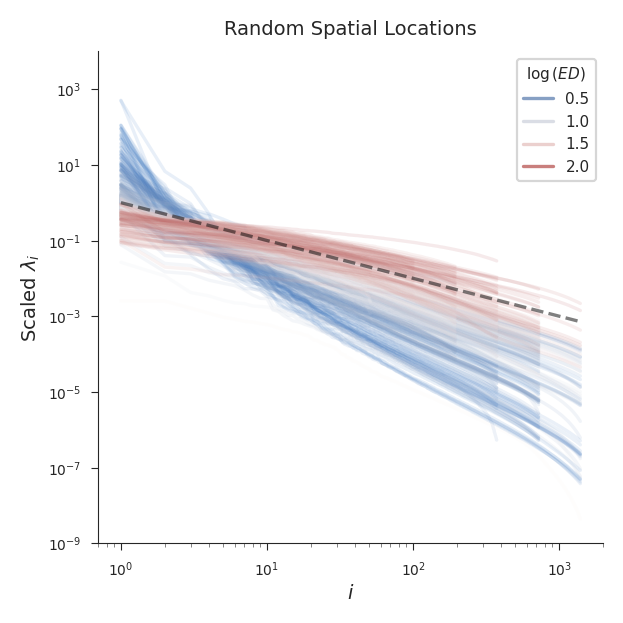

In [7]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results_marcc/spatialPCA/eigspectra|dataset:{dataset}|pooling:random_spatial|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/spatialPCA/eigmetrics|dataset:{dataset}|pooling:random_spatial|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = np.log10(data['effective dimensionality'])

fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Random Spatial Locations')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')

#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()

(0.4, 3.5)

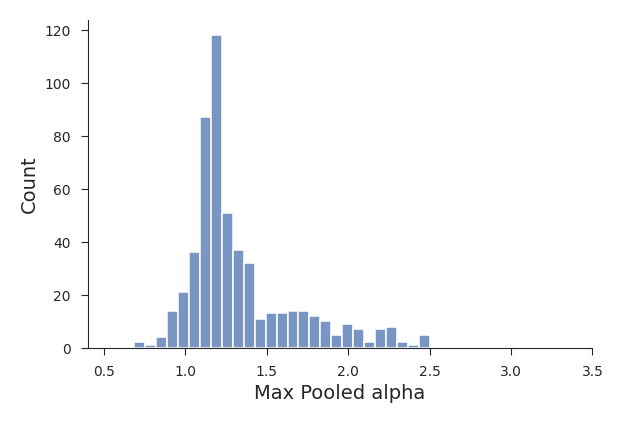

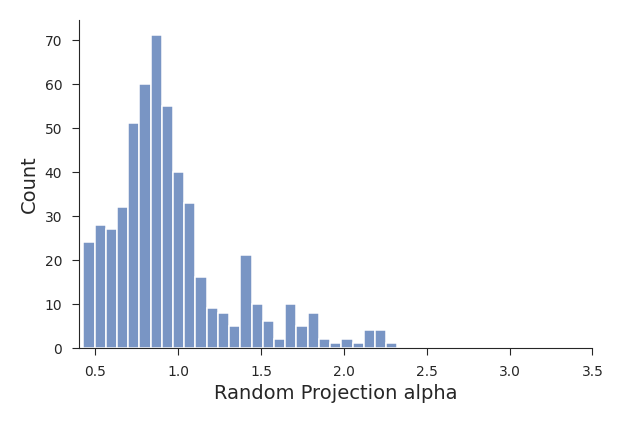

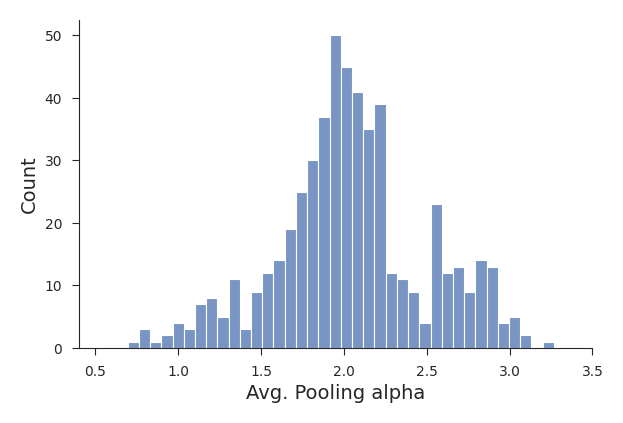

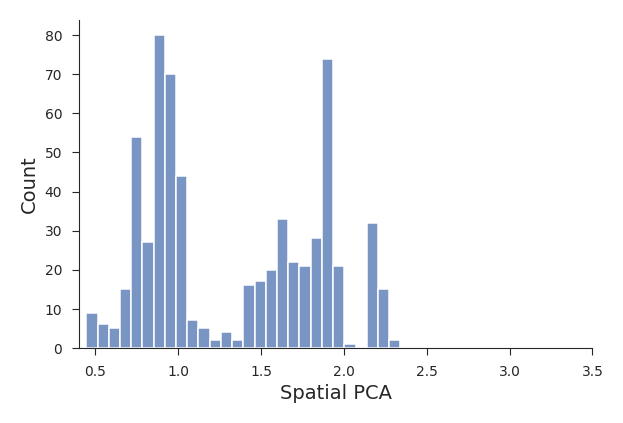

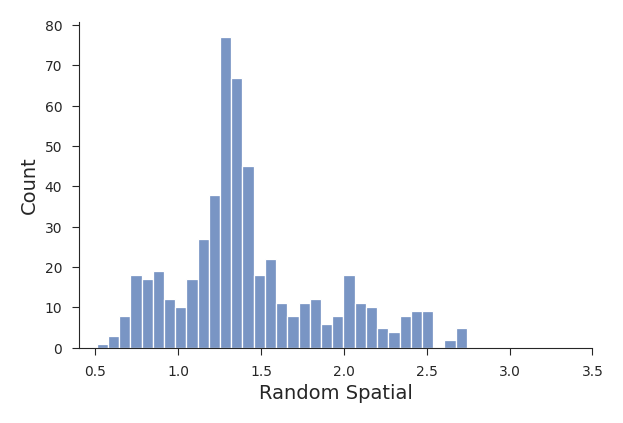

In [5]:
#histogram of alphas with different pooling & spatial pca
dataset = 'imagenet'
#max pooling
data = pd.read_csv(f'../../results_marcc/reproductions/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv')
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

Q_1 = np.quantile(data['alpha'], 0.25)
Q_3 = np.quantile(data['alpha'], 0.75)
IQR = Q_3 - Q_1
cube = np.cbrt(len(data['alpha']))
bw = 2* IQR/ cube
nb = 1/(2*IQR/cube)

fig, ax = plt.subplots(figsize=(3, 2))
sns.histplot(data=data, x='alpha')
ax.set(xlabel='Max Pooled alpha')
ax.set_xlim(0.4, 3.5)
#ax.set_ylim(bottom=0, top=0.65)

#no pooling
data_np = pd.read_csv(f'../../results_marcc/reproductions/eigmetrics|dataset:{dataset}|pooling:False|grayscale:False.csv')
data_np.loc[:, 'layer'] = data_np['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
sns.histplot(data=data_np, x='alpha', binwidth=bw)
ax.set(xlabel='Random Projection alpha')
ax.set_xlim(0.4, 3.5)
#ax.set_ylim(bottom=0, top=0.65)

#avg pooling
data_ap = pd.read_csv(f'../../results_marcc/reproductions/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv')
data_ap.loc[:, 'layer'] = data_ap['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
sns.histplot(data=data_ap, x='alpha', binwidth=bw)
ax.set(xlabel='Avg. Pooling alpha')
ax.set_xlim(0.4, 3.5)
#ax.set_ylim(bottom=0, top=0.65)

#spatial pca
data_sp = pd.read_csv(f'../../results_marcc/spatialPCA/eigmetrics_5x|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv')
data_sp.loc[:, 'layer'] = data_sp['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
sns.histplot(data=data_sp, x='alpha', binwidth=bw)
ax.set(xlabel='Spatial PCA')
ax.set_xlim(0.4, 3.5)
#ax.set_ylim(bottom=0, top=0.65)

#random spatial
data_rs = pd.read_csv(f'../../results_marcc/spatialPCA/eigmetrics|dataset:{dataset}|pooling:random_spatial|grayscale:False.csv')
data_rs.loc[:, 'layer'] = data_rs['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
sns.histplot(data=data_rs, x='alpha', binwidth=bw)
ax.set(xlabel='Random Spatial')
ax.set_xlim(0.4, 3.5)
#ax.set_ylim(bottom=0, top=0.65)

(0.0, 0.6)

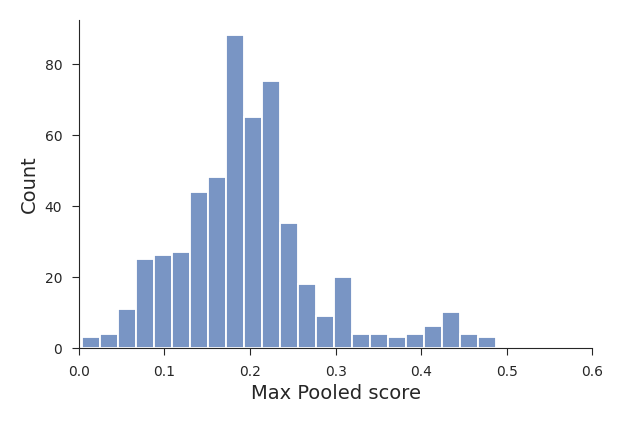

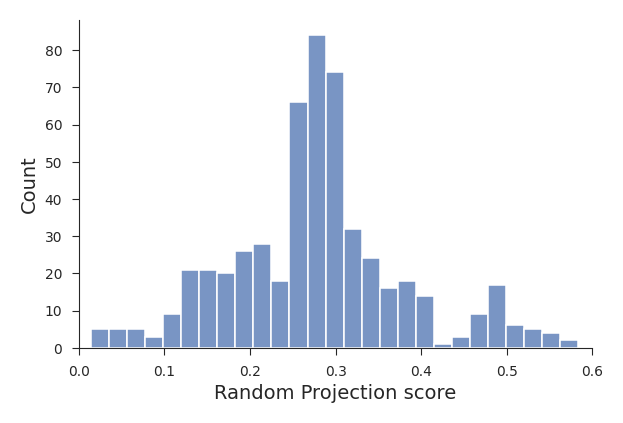

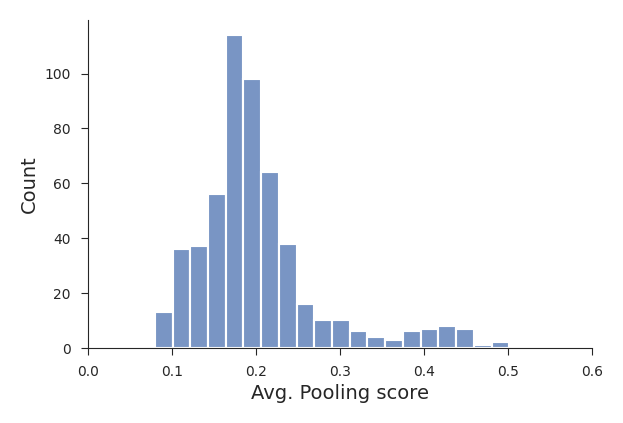

In [6]:
#histogram of encoding score with different pooling & spatial pca

#max pooling
data = pd.read_csv(f'../../results_marcc/reproductions/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:True.csv')
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

Q_1 = np.quantile(data['score'], 0.25)
Q_3 = np.quantile(data['score'], 0.75)
IQR = Q_3 - Q_1
cube = np.cbrt(len(data['score']))
bw = 2* IQR/ cube
nb = 1/(2*IQR/cube)

fig, ax = plt.subplots(figsize=(3, 2))
sns.histplot(data=data, x='score')
ax.set(xlabel='Max Pooled score')
ax.set_xlim(0, 0.6)
#ax.set_ylim(bottom=0, top=0.65)

#no pooling
data_np = pd.read_csv(f'../../results_marcc/reproductions/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv')
data_np.loc[:, 'layer'] = data_np['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
sns.histplot(data=data_np, x='score', binwidth=bw)
ax.set(xlabel='Random Projection score')
ax.set_xlim(0, 0.6)
#ax.set_ylim(bottom=0, top=0.65)

#avg pooling
data_ap = pd.read_csv(f'../../results_marcc/reproductions/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:avg.csv')
data_ap.loc[:, 'layer'] = data_ap['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
sns.histplot(data=data_ap, x='score', binwidth=bw)
ax.set(xlabel='Avg. Pooling score')
ax.set_xlim(0, 0.6)
#ax.set_ylim(bottom=0, top=0.65)



#random spatial


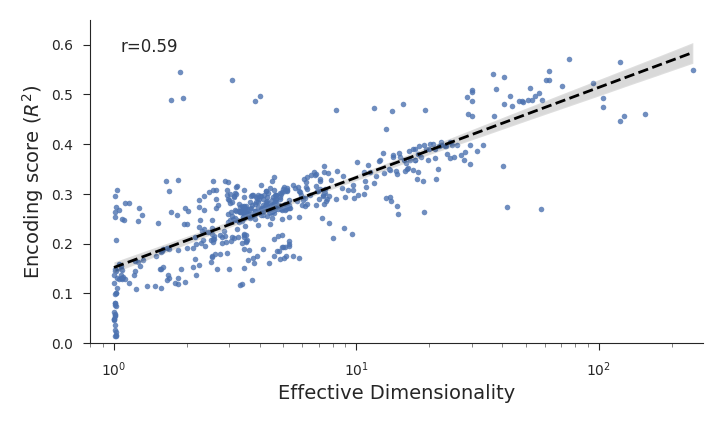

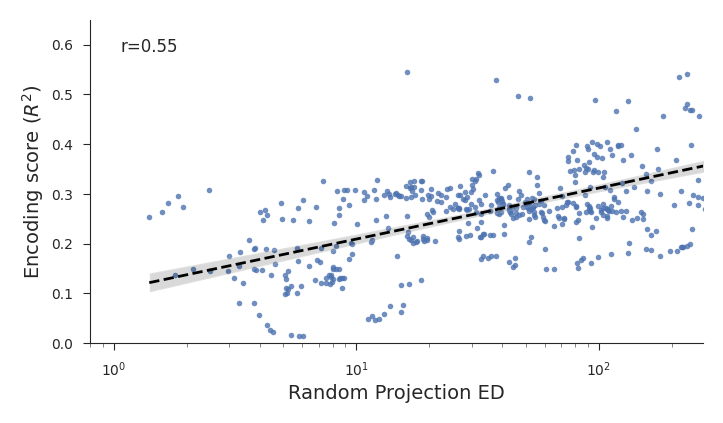

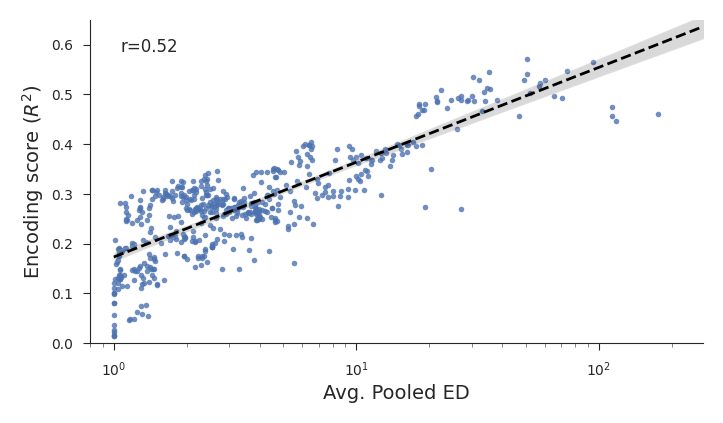

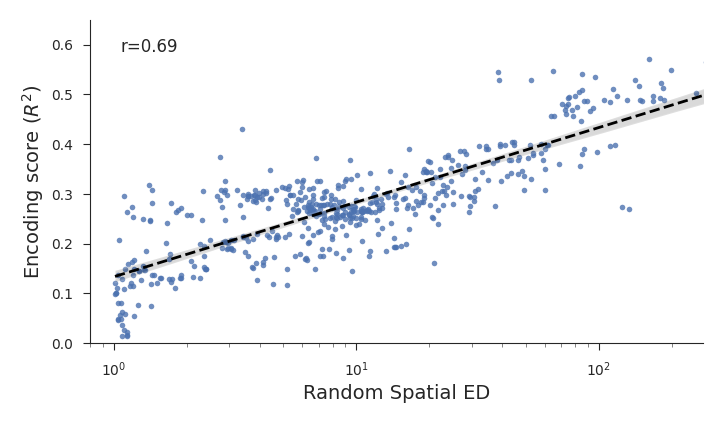

In [2]:
#encoding score & ED
dataset = 'imagenet'
#max pooling
data = pd.merge(pd.read_csv(f'../../results_marcc/reproductions/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results_marcc/reproductions/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

r, p = sp.stats.pearsonr(data['effective dimensionality'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

ax.set_xlim(0.8, 270)
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Max Pooled ED', ylabel=r'Encoding score ($R^2$)', xscale='log')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
ax.set_ylim(bottom=0, top=0.65)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()

#no pooling
data_np = pd.merge(pd.read_csv(f'../../results_marcc/reproductions/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results_marcc/reproductions/eigmetrics|dataset:{dataset}|pooling:False|grayscale:False.csv'),
                on=id_columns)
data_np.loc[:, 'layer'] = data_np['layer'].replace(tf_to_pt_layer_map)

r_np, p_np = sp.stats.pearsonr(data_np['effective dimensionality'], data_np['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

ax.set_xlim(0.8, 270)
sns.regplot(data=data_np, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Random Projection ED', ylabel=r'Encoding score ($R^2$)', xscale='log')
ax.text(.05, .9, 'r={:.2f}'.format(r_np), transform=ax.transAxes)
ax.set_ylim(bottom=0, top=0.65)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()

#avg pooling
data_ap = pd.merge(pd.read_csv(f'../../results_marcc/reproductions/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results_marcc/reproductions/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv'),
                on=id_columns)
data_ap.loc[:, 'layer'] = data_ap['layer'].replace(tf_to_pt_layer_map)

r_ap, p_ap = sp.stats.pearsonr(data_ap['effective dimensionality'], data_ap['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

ax.set_xlim(0.8, 270)
sns.regplot(data=data_ap, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Avg. Pooled ED', ylabel=r'Encoding score ($R^2$)', xscale='log')
ax.text(.05, .9, 'r={:.2f}'.format(r_ap), transform=ax.transAxes)
ax.set_ylim(bottom=0, top=0.65)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#random spatial
data_rs = pd.merge(pd.read_csv(f'../../results_marcc/reproductions/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results_marcc/spatialPCA/eigmetrics|dataset:{dataset}|pooling:random_spatial|grayscale:False.csv'),
                on=id_columns)
data_rs.loc[:, 'layer'] = data_rs['layer'].replace(tf_to_pt_layer_map)

r_rs, p_rs = sp.stats.pearsonr(data_rs['effective dimensionality'], data_rs['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

ax.set_xlim(0.8, 270)
sns.regplot(data=data_rs, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Random Spatial ED', ylabel=r'Encoding score ($R^2$)', xscale='log')
ax.text(.05, .9, 'r={:.2f}'.format(r_rs), transform=ax.transAxes)
ax.set_ylim(bottom=0, top=0.65)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()

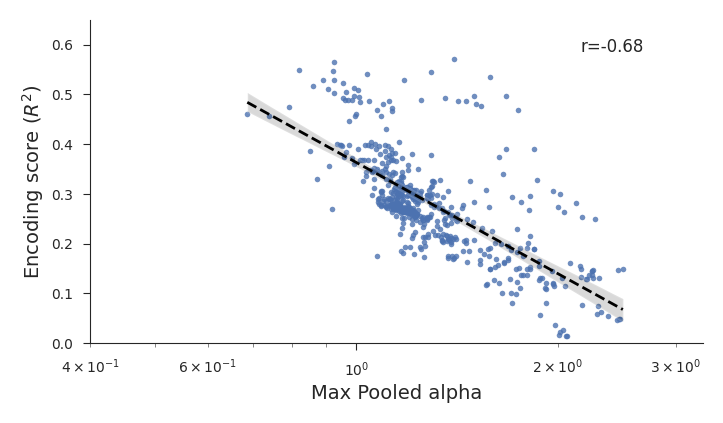

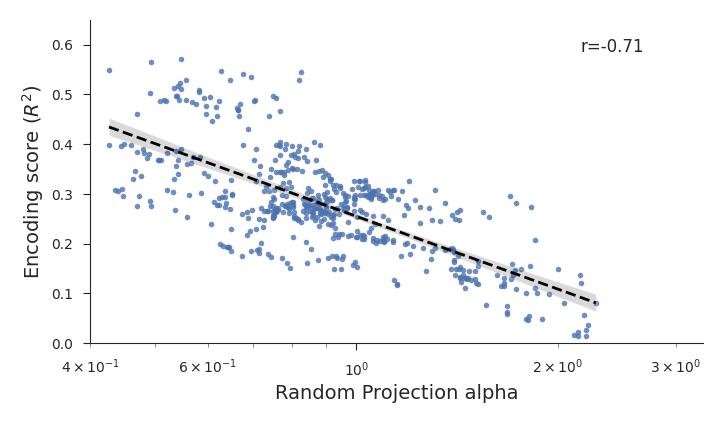

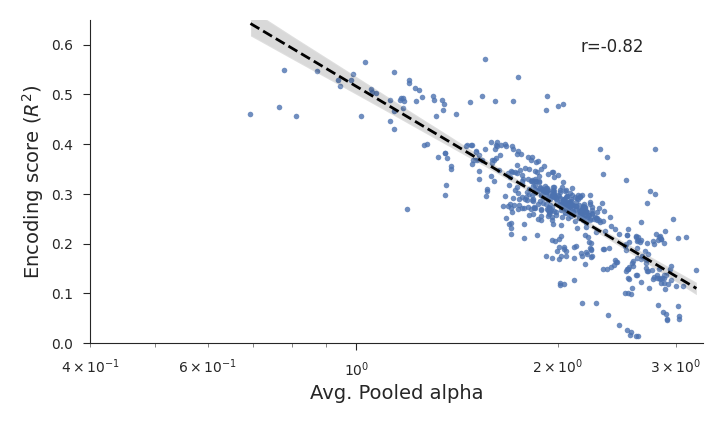

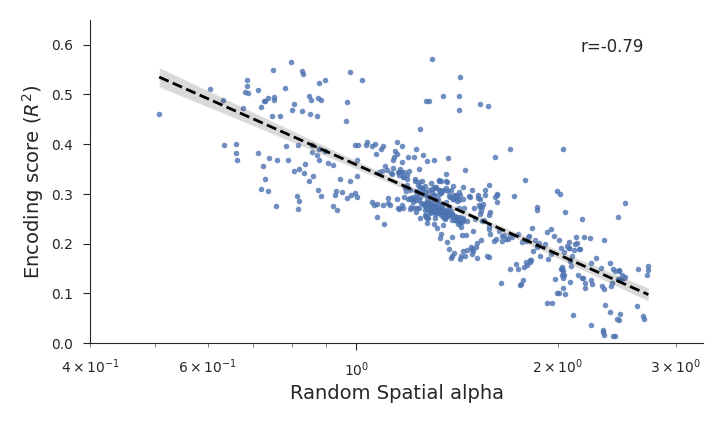

In [17]:
#encoding score & alpha
dataset = 'imagenet'
#max pooling
data = pd.merge(pd.read_csv(f'../../results_marcc/reproductions/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results_marcc/reproductions/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

r, p = sp.stats.pearsonr(data['alpha'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='alpha', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Max Pooled alpha', ylabel=r'Encoding score ($R^2$)', xscale='log')
ax.text(.8, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
ax.set_xlim(0.4, 3.3)
ax.set_ylim(bottom=0, top=0.65)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()

#no pooling
data_np = pd.merge(pd.read_csv(f'../../results_marcc/reproductions/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results_marcc/reproductions/eigmetrics|dataset:{dataset}|pooling:False|grayscale:False.csv'),
                on=id_columns)
data_np.loc[:, 'layer'] = data_np['layer'].replace(tf_to_pt_layer_map)

r_np, p_np = sp.stats.pearsonr(data_np['alpha'], data_np['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data_np, x='alpha', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Random Projection alpha', ylabel=r'Encoding score ($R^2$)', xscale='log')
ax.text(.8, .9, 'r={:.2f}'.format(r_np), transform=ax.transAxes)
ax.set_xlim(0.4, 3.3)
ax.set_ylim(bottom=0, top=0.65)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#avg pooling
data_ap = pd.merge(pd.read_csv(f'../../results_marcc/reproductions/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results_marcc/reproductions/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv'),
                on=id_columns)
data_ap.loc[:, 'layer'] = data_ap['layer'].replace(tf_to_pt_layer_map)

r_ap, p_ap = sp.stats.pearsonr(data_ap['alpha'], data_ap['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data_ap, x='alpha', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Avg. Pooled alpha', ylabel=r'Encoding score ($R^2$)', xscale='log')
ax.text(.8, .9, 'r={:.2f}'.format(r_ap), transform=ax.transAxes)
ax.set_xlim(0.4, 3.3)
ax.set_ylim(bottom=0, top=0.65)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#random spatial
data_rs = pd.merge(pd.read_csv(f'../../results_marcc/reproductions/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results_marcc/spatialPCA/eigmetrics|dataset:{dataset}|pooling:random_spatial|grayscale:False.csv'),
                on=id_columns)
data_rs.loc[:, 'layer'] = data_rs['layer'].replace(tf_to_pt_layer_map)

r_rs, p_rs = sp.stats.pearsonr(data_rs['alpha'], data_rs['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data_rs, x='alpha', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Random Spatial alpha', ylabel=r'Encoding score ($R^2$)', xscale='log')
ax.text(.8, .9, 'r={:.2f}'.format(r_rs), transform=ax.transAxes)
ax.set_xlim(0.4, 3.3)
ax.set_ylim(bottom=0, top=0.65)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()

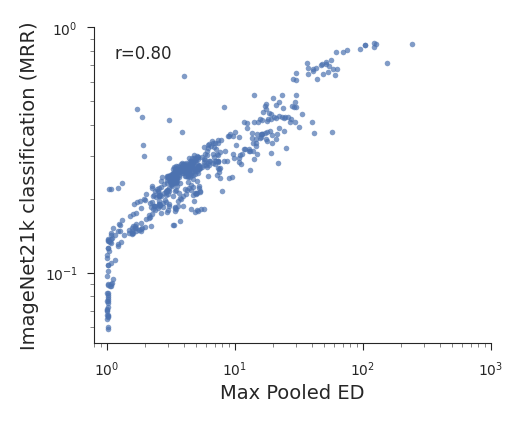

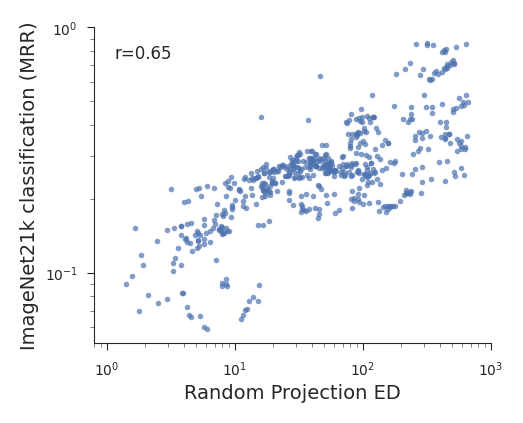

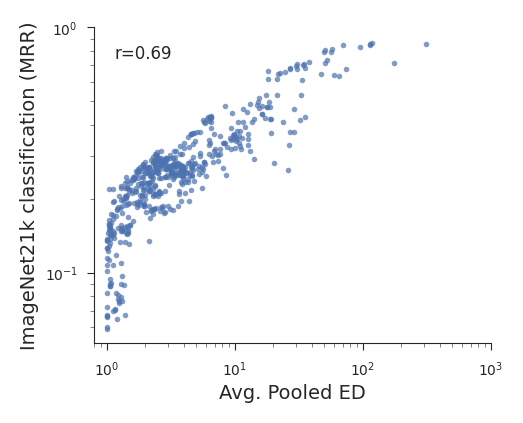

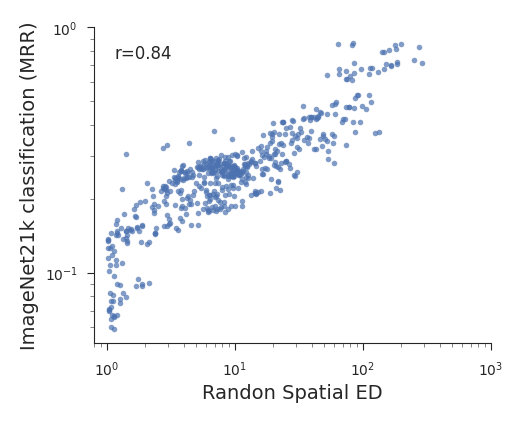

In [7]:
#classification & ED
dataset = 'imagenet'
data = pd.read_csv(f'../../results_marcc/reproductions/n-shot|dataset:imagenet21k|classifier:prototype|pooling:True.csv')
data = data[data.n_train == 50]
data = data.drop([c for c in data.columns if c not in id_columns + ['MRR']], axis='columns')
data = data.groupby(id_columns, as_index=False).mean()

#max pooled
data_mp = pd.merge(data, 
                pd.read_csv(f'../../results_marcc/reproductions/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv'), 
                on=id_columns)
data_mp.loc[:, 'layer'] = data_mp['layer'].replace(tf_to_pt_layer_map)

r, p = sp.stats.pearsonr(data_mp['effective dimensionality'], data_mp['MRR'])

fig, ax = plt.subplots(figsize=(2.5, 2))

sns.scatterplot(data=data_mp, x='effective dimensionality', y='MRR',
                alpha=0.7, s=4, linewidth=0, ax=ax)
ax.set(xscale='log', yscale='log', xlabel='Max Pooled ED', ylabel='ImageNet21k classification (MRR)')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
ax.set_ylim(top=1)
ax.set_xlim(0.8, 1000)
#annotate_corr(data, x='effective dimensionality', y='MRR', pos=(0.55, 0.2), ax=ax)
#plt.savefig('saved/results_classification-plot.png', dpi=300)
plt.show()

#no pooling
data_np = pd.merge(data, 
                pd.read_csv(f'../../results_marcc/reproductions/eigmetrics|dataset:{dataset}|pooling:False|grayscale:False.csv'), 
                on=id_columns)
data_np.loc[:, 'layer'] = data_np['layer'].replace(tf_to_pt_layer_map)

r_np, p_np = sp.stats.pearsonr(data_np['effective dimensionality'], data_np['MRR'])

fig, ax = plt.subplots(figsize=(2.5, 2))

sns.scatterplot(data=data_np, x='effective dimensionality', y='MRR',
                alpha=0.7, s=4, linewidth=0, ax=ax)
ax.set(xscale='log', yscale='log', xlabel='Random Projection ED', ylabel='ImageNet21k classification (MRR)')
ax.text(.05, .9, 'r={:.2f}'.format(r_np), transform=ax.transAxes)
ax.set_ylim(top=1)
ax.set_xlim(0.8, 1000)
#annotate_corr(data, x='effective dimensionality', y='MRR', pos=(0.55, 0.2), ax=ax)
#plt.savefig('saved/results_classification-plot.png', dpi=300)
plt.show()

#avg pooling
data_ap = pd.merge(data, 
                pd.read_csv(f'../../results_marcc/reproductions/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv'), 
                on=id_columns)
data_ap.loc[:, 'layer'] = data_ap['layer'].replace(tf_to_pt_layer_map)

r_ap, p_ap = sp.stats.pearsonr(data_ap['effective dimensionality'], data_ap['MRR'])

fig, ax = plt.subplots(figsize=(2.5, 2))

sns.scatterplot(data=data_ap, x='effective dimensionality', y='MRR',
                alpha=0.7, s=4, linewidth=0, ax=ax)
ax.set(xscale='log', yscale='log', xlabel='Avg. Pooled ED', ylabel='ImageNet21k classification (MRR)')
ax.text(.05, .9, 'r={:.2f}'.format(r_ap), transform=ax.transAxes)
ax.set_ylim(top=1)
ax.set_xlim(0.8, 1000)
#annotate_corr(data, x='effective dimensionality', y='MRR', pos=(0.55, 0.2), ax=ax)
#plt.savefig('saved/results_classification-plot.png', dpi=300)
plt.show()


#random_spatial
data_rs = pd.merge(data, 
                pd.read_csv(f'../../results_marcc/spatialPCA/eigmetrics|dataset:imagenet|pooling:random_spatial|grayscale:False.csv'), 
                on=id_columns)
data_rs.loc[:, 'layer'] = data_rs['layer'].replace(tf_to_pt_layer_map)

r_rs, p_ap = sp.stats.pearsonr(data_rs['effective dimensionality'], data_rs['MRR'])

fig, ax = plt.subplots(figsize=(2.5, 2))

sns.scatterplot(data=data_rs, x='effective dimensionality', y='MRR',
                alpha=0.7, s=4, linewidth=0, ax=ax)
ax.set(xscale='log', yscale='log', xlabel='Randon Spatial ED', ylabel='ImageNet21k classification (MRR)')
ax.text(.05, .9, 'r={:.2f}'.format(r_rs), transform=ax.transAxes)
ax.set_ylim(top=1)
ax.set_xlim(0.8, 1000)
#annotate_corr(data, x='effective dimensionality', y='MRR', pos=(0.55, 0.2), ax=ax)
#plt.savefig('saved/results_classification-plot.png', dpi=300)
plt.show()

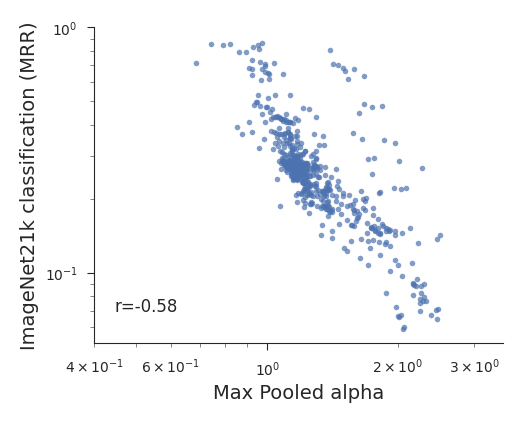

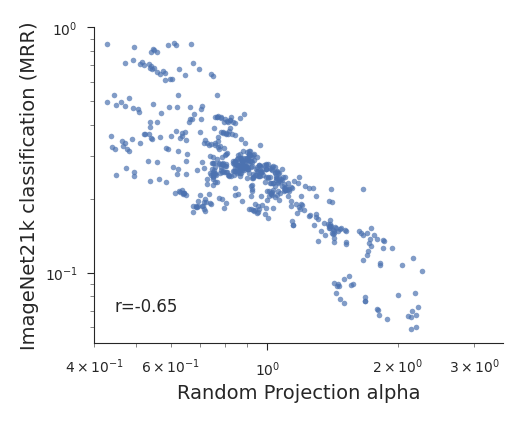

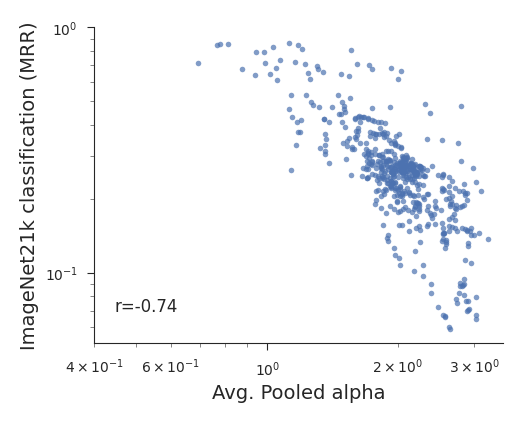

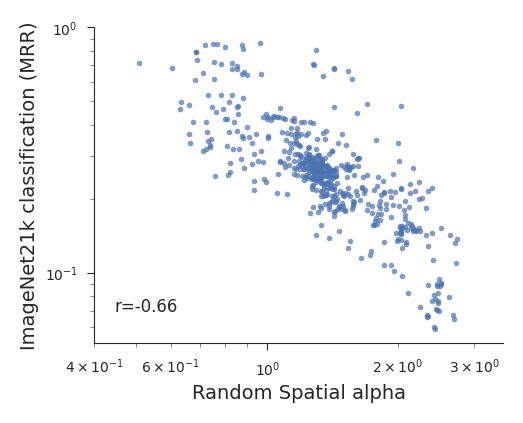

In [5]:
#classification & alpha
dataset = 'imagenet'
data = pd.read_csv(f'../../results_marcc/reproductions/n-shot|dataset:imagenet21k|classifier:prototype|pooling:True.csv')
data = data[data.n_train == 50]
data = data.drop([c for c in data.columns if c not in id_columns + ['MRR']], axis='columns')
data = data.groupby(id_columns, as_index=False).mean()

#max pooled
data_mp = pd.merge(data, 
                pd.read_csv(f'../../results_marcc/reproductions/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv'), 
                on=id_columns)
data_mp.loc[:, 'layer'] = data_mp['layer'].replace(tf_to_pt_layer_map)

r, p = sp.stats.pearsonr(data_mp['alpha'], data_mp['MRR'])

fig, ax = plt.subplots(figsize=(2.5, 2))

sns.scatterplot(data=data_mp, x='alpha', y='MRR',
                alpha=0.7, s=4, linewidth=0, ax=ax)
ax.set(xscale='log', yscale='log', xlabel='Max Pooled alpha', ylabel='ImageNet21k classification (MRR)')
ax.text(.05, .1, 'r={:.2f}'.format(r), transform=ax.transAxes)
ax.set_ylim(top=1)
ax.set_xlim(0.4, 3.5)
#annotate_corr(data, x='effective dimensionality', y='MRR', pos=(0.55, 0.2), ax=ax)
#plt.savefig('saved/results_classification-plot.png', dpi=300)
plt.show()

#no pooling
data_np = pd.merge(data, 
                pd.read_csv(f'../../results_marcc/reproductions/eigmetrics|dataset:{dataset}|pooling:False|grayscale:False.csv'), 
                on=id_columns)
data_np.loc[:, 'layer'] = data_np['layer'].replace(tf_to_pt_layer_map)

r_np, p_np = sp.stats.pearsonr(data_np['alpha'], data_np['MRR'])

fig, ax = plt.subplots(figsize=(2.5, 2))

sns.scatterplot(data=data_np, x='alpha', y='MRR',
                alpha=0.7, s=4, linewidth=0, ax=ax)
ax.set(xscale='log', yscale='log', xlabel='Random Projection alpha', ylabel='ImageNet21k classification (MRR)')
ax.text(.05, .1, 'r={:.2f}'.format(r_np), transform=ax.transAxes)
ax.set_ylim(top=1)
ax.set_xlim(0.4, 3.5)
#annotate_corr(data, x='effective dimensionality', y='MRR', pos=(0.55, 0.2), ax=ax)
#plt.savefig('saved/results_classification-plot.png', dpi=300)
plt.show()

#avg pooling
data_ap = pd.merge(data, 
                pd.read_csv(f'../../results_marcc/reproductions/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv'), 
                on=id_columns)
data_ap.loc[:, 'layer'] = data_ap['layer'].replace(tf_to_pt_layer_map)

r_ap, p_ap = sp.stats.pearsonr(data_ap['alpha'], data_ap['MRR'])

fig, ax = plt.subplots(figsize=(2.5, 2))

sns.scatterplot(data=data_ap, x='alpha', y='MRR',
                alpha=0.7, s=4, linewidth=0, ax=ax)
ax.set(xscale='log', yscale='log', xlabel='Avg. Pooled alpha', ylabel='ImageNet21k classification (MRR)')
ax.text(.05, .1, 'r={:.2f}'.format(r_ap), transform=ax.transAxes)
ax.set_ylim(top=1)
ax.set_xlim(0.4, 3.5)
#annotate_corr(data, x='effective dimensionality', y='MRR', pos=(0.55, 0.2), ax=ax)
#plt.savefig('saved/results_classification-plot.png', dpi=300)
plt.show()


#random_spatial
data_rs = pd.merge(data, 
                pd.read_csv(f'../../results_marcc/spatialPCA/eigmetrics|dataset:imagenet|pooling:random_spatial|grayscale:False.csv'), 
                on=id_columns)
data_rs.loc[:, 'layer'] = data_rs['layer'].replace(tf_to_pt_layer_map)

r_rs, p_rs = sp.stats.pearsonr(data_rs['alpha'], data_rs['MRR'])

fig, ax = plt.subplots(figsize=(2.5, 2))

sns.scatterplot(data=data_rs, x='alpha', y='MRR',
                alpha=0.7, s=4, linewidth=0, ax=ax)
ax.set(xscale='log', yscale='log', xlabel='Random Spatial alpha', ylabel='ImageNet21k classification (MRR)')
ax.text(.05, .1, 'r={:.2f}'.format(r_rs), transform=ax.transAxes)
ax.set_ylim(top=1)
ax.set_xlim(0.4, 3.5)
#annotate_corr(data, x='effective dimensionality', y='MRR', pos=(0.55, 0.2), ax=ax)
#plt.savefig('saved/results_classification-plot.png', dpi=300)
plt.show()